# Capstone

### Stock Data Source

*Plan to replace this in the future with a self updating pull using pandas_datareader.data<br>*

- Dow Jones Data Source
https://fred.stlouisfed.org/series/DJIA/downloaddata

- SP500 Data Source
https://fred.stlouisfed.org/series/SP500/downloaddata

## Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import zipfile
import glob
import urllib
import logging
import pickle
import xgboost
import time

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_predict


from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

# Deprecated yet if I use the new version it breaks my code so this stays in until I fix it.
from sklearn.cross_validation import StratifiedKFold


from pydub import AudioSegment
from pydub.playback import play

from datetime import datetime, date, time, timedelta
import pandas_datareader.data as web


seinfeld = AudioSegment.from_mp3("theme.mp3")[:11500]
plt.style.use('fivethirtyeight')
%matplotlib inline

## Logging

In [3]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# create a file handler
handler = logging.FileHandler('logfile.log')
handler.setLevel(logging.DEBUG)

# create a logging format
formatter = logging.Formatter('%(asctime)s - %(message)s')
handler.setFormatter(formatter)

# add the handlers to the logger
logger.addHandler(handler)

## SP500 Download

In [315]:
df = pd.read_csv('/Users/Jesse/Downloads/SP500.csv')
df['VALUE'] = df['VALUE'].replace('.', np.nan)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df['Date'] = pd.to_datetime(df['DATE'])

df['DATE'] = [''.join(re.findall('(\d*)', df['DATE'][x])[::2]) for x in range(len(df))]

df['Date'] = df['Date'] - timedelta(days=1)
df['Date'] = [str(df['Date'][x].year) + '{:02d}'.format(df['Date'][x].month) + '{:02d}'.format(df['Date'][x].day) for x in range(len(df))]



# This whole section is a temporary bandaide.
# Better implementation to replace the above section on TO-DO list.
start = datetime(2015, 02, 20)
end = datetime(2016, 11, 23)
moob = web.DataReader('SPY', 'google', start, end)
moob.reset_index(inplace=True)
ddf = pd.read_csv('/Users/Jesse/Downloads/SP500.csv')
ddf['VALUE'] = ddf['VALUE'].replace('.', np.nan)
ddf.dropna(inplace=True)
ddf.reset_index(drop=True, inplace=True)
ddf['DATE'] = pd.to_datetime(ddf['DATE'])
moob.set_index(moob['Date'], inplace=True)
ddf.set_index(ddf['DATE'], inplace=True)
ddf['Open'] = moob['Open']
ddf['Close'] = moob['Close']
ddf['day_diff'] = ddf['Close'] - ddf['Open']
ddf.reset_index(drop=True, inplace=True)

# Functions

## Data Download

In [5]:
# Needs more work but pulls data from gdelt and saves it system.
def download_data(day_of, day_before):
    day_before_begin = 144500    # 9:45 am (EST) :  2:45 pm (GMT)
    day_before_end   = 234500    # 6:45 pm (EST) : 11:45 pm (GMT)
    day_of_begin     = 0         # 7:00 pm (EST) : 12:00 am (GMT)
    day_of_end       = 143000    # 9:30 am (EST) :  2:30 pm (GMT)
    while (day_before_begin <= day_before_end):
        x1 = day_before + str(day_before_begin) + '.gkg.csv.zip'
        x2 = 'http://data.gdeltproject.org/gdeltv2/' + x1
        day_before_begin+=1500
        if str(60) in str(day_before_begin):
            day_before_begin+=4000
        x3 = 'capzips/' + x1
        urllib.urlretrieve(x2, x3)
        
    while (day_of_begin <= day_of_end):
        x1 = day_of + '{:06d}'.format(day_of_begin) + '.gkg.csv.zip'
        x2 = 'http://data.gdeltproject.org/gdeltv2/' + x1
        day_of_begin+=1500
        if str(60) in str(day_of_begin):
            day_of_begin+=4000
        x3 = 'capzips/' + x1
        urllib.urlretrieve(x2, x3)
    extract_zip()

# Reads every zip file in the folder and extracts them then deletes the zip.
def extract_zip():
    for name in glob.glob('capzips/*.zip'):
        try:
            with zipfile.ZipFile(name, 'r') as myzip:
                myzip.extractall('capzips/')
                os.remove(name)
        except:
            os.remove(name)

## CSV to DataFrame

In [6]:
# Opens every csv and puts the data into a dataframe
def csv_to_df_no_GCAM():
    csv_df = pd.DataFrame()
    #count=0
    for name in glob.glob('capzips/*.csv'):
        try:
            logger.debug('File name: %s', name)
            temp_df = pd.read_csv(name, header=None, sep="\t", usecols=[1,15])
            temp_df['Date'], temp_df['TONE'] = temp_df[1], temp_df[15]
            temp_df = temp_df[['Date', 'TONE']]
            
            # This section is necessary do not remove.
            if temp_df['Date'].dtypes != 'int64':
                temp_df.dropna(inplace=True)
                temp_df['Date'] = temp_df['Date'].astype(int)
        
            csv_df = pd.concat((csv_df,temp_df), ignore_index=True)
        except:
            logger.debug('File is empty: %s', name)
        #count+=1
    return csv_df


# Deletes the CSVs
def delete_csv():
    for name in glob.glob('capzips/*.csv'):
        os.remove(name)

## Random Functions

In [7]:
# Used to run data collection in specified time increments.
# Current implementation takes 5 minutes to run.
def run_time(t, x):
    if x == 'm':
        return t/5
    else:
        return (t*60)/5


def tone_parse(cvs):
    cvs['tone'] = [float(x.split(',')[0]) for x in cvs['TONE']]
    cvs['positive_score'] = [float(x.split(',')[1]) for x in cvs['TONE']]
    cvs['negative_score'] = [float(x.split(',')[2]) for x in cvs['TONE']]
    cvs['polarity'] = [float(x.split(',')[3]) for x in cvs['TONE']]
    cvs['activity'] = [float(x.split(',')[4]) for x in cvs['TONE']]
    cvs['word_count'] = [int(x.split(',')[6]) for x in cvs['TONE']]
    cvs.pop('TONE')
    return cvs

## Main

In [8]:
def main_func(time_run):
    if time_run == 0:
        return "Not enough time to finish one loop."
    
    # We good fam.
    try:
        final_df = pd.read_pickle('last_df.pkl')
    except IOError:
        final_df = pd.DataFrame()
    
    
    # Prevents my program from running over and breaking.
    if len(final_df)+time_run >= len(df):
        upper_bound = len(df)-1
    else:
        upper_bound = len(final_df)+time_run
    
    # Main for loop that downloads, cleans, and stores relevant data.
    for p in range(len(final_df), upper_bound):
        # Downloads the data from the internet for the specified date.
        download_data(df['DATE'][p], df['Date'][p])
        
        
        # --------- TONE Section -------- #
        csv_df = tone_parse(csv_to_df_no_GCAM())
        csv_df['Date'] = [pd.to_datetime(datetime.strptime(str(x), '%Y%m%d%H%M%S')) for x in csv_df['Date']]
        csv_df = csv_df.set_index('Date')
        csv_df = csv_df.resample('h').mean()
        csv_df.dropna(inplace=True)
        csv_df.reset_index(inplace=True)
        temp = csv_df.columns[1:]
        test = pd.DataFrame([np.polyfit(csv_df.index, csv_df[x],1)[0] for x in csv_df.columns[1:].tolist()]).T
        test.columns = temp.tolist()
        # --------- TONE Section -------- #

        
        final_df = pd.concat([final_df, test], ignore_index=True)
        delete_csv()
        final_df['Date'] = df['DATE']
        pd.to_pickle(final_df, 'last_df.pkl')
        final_df = pd.read_pickle('last_df.pkl')
    play(seinfeld)

In [9]:
# Runs main function
# main_func(run_time(20, 'm')) # m = minutes, h = hours      1 loop = ~5 minutes

In [316]:
testDF = pd.read_pickle('last_df.pkl')
testDF['value'] = ddf['day_diff']
testDF['shifted_value'] = testDF[[7]].shift()
testDF['Volatility'] = (testDF['value'].rolling(window=7,center=False).std()*np.sqrt(52)).shift()
testDF.dropna(inplace=True)
testDF.reset_index(drop=True, inplace=True)
testDF['value_binary'] = [1 if float(x) > 0 else 0 for x in testDF['value']]
testDF.head()

,Date,activity,negative_score,polarity,positive_score,tone,word_count,value,shifted_value,Volatility,value_binary
0,20150303,-0.002042,-0.004188,-0.004990,-0.000803,0.003385,0.099662,-0.35,1.21,5.935257,0
1,20150304,-0.002408,-0.003338,-0.002785,0.000552,0.003890,0.921975,-0.17,-0.35,4.521195,0
2,20150305,-0.003321,-0.008528,-0.006243,0.002284,0.010812,0.444884,-0.16,-0.17,4.578665,0
3,20150306,0.004545,0.001455,0.001000,-0.000455,-0.001911,0.292905,-1.92,-0.16,4.177226,0
4,20150309,-0.012258,-0.012414,-0.008342,0.004072,0.016486,-0.678822,0.62,-1.92,6.621512,1


In [360]:
# Test Model Performance by finding mean scores of 100 runs.
# Problem is this finds the mean of different Y's which have different values every time.
# This is bad.

final_results = []
default_results = []
test_results = []
base_accuracy = []
better_count = 0

for count in range(100):
    X = testDF[[1,2,3,4,5,6,8,9]]
    y = testDF["value_binary"]

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    
    
#     X_train = testDF[[1,2,3,4,5,6,8,9]][:-10]
#     Y_train = testDF['value_binary'][:-10]

#     X_test = testDF[[1,2,3,4,5,6,8,9]][-10:]
#     Y_test = testDF['value_binary'][-10:]

    
    
    #lr = xgboost.XGBClassifier()
    lr = LogisticRegressionCV(Cs=15, cv=10)
    lr.fit(X_train,Y_train)

    y_pred = lr.predict(X_test)

    #--------This section needs to be re-evaluated and editted--------#  Done?
    Y_test_index = pd.DataFrame(Y_test).reset_index()
    Y_test_and_predict = pd.concat((Y_test_index, pd.DataFrame(y_pred)),axis=1)

    Y_test_and_predict = Y_test_and_predict.set_index('index')
    Y_test_and_predict['guess'] = Y_test_and_predict[0]
    Y_test_and_predict.pop(0)
    fest = pd.concat((Y_test_and_predict, testDF['value']), axis=1).dropna()
    fest.reset_index(drop=True, inplace=True)

    positive, negative = 0, 0
    for x in range(len(fest)):
        if fest['guess'][x] == 1:
            if fest['value_binary'][x] == fest['guess'][x]:
                positive += abs(fest['value'][x])
            else:
                negative += abs(fest['value'][x])
    #---------------------------------------------------------------#
    
    results = positive - negative
    final_results.append(results)
    
    conmat = confusion_matrix(Y_test, y_pred, labels=[1,0])
    test_results.append((conmat[0][0]+conmat[1][1])/float(len(Y_test)))
    
    #if conmat[0][0] + conmat[0][1] > conmat[1][0] + conmat[1][1]:
    base_accuracy.append((conmat[0][0]+conmat[0][1])/float(len(Y_test)))
    #else:
    #    base_accuracy.append((conmat[1][0]+conmat[1][1])/float(len(Y_test)))
    
    right_pos = [x for x in fest['value'] if x > 0]
    right_neg = [x for x in fest['value'] if x < 0]
    dresults = np.sum(right_pos) - abs(np.sum(right_neg))
    default_results.append(dresults)
    
    if results >= dresults:
        better_count+=1
print "Mean S&P500 Model Performance:", np.mean(final_results), "Ignore."
print "Mean S&P500  Base Performance:", np.mean(default_results), "Ignore."
print 'Mean of Model Accuracy:', np.mean(test_results)
print 'Mean of  Base Accuracy:', np.mean(base_accuracy)
print 'Model Standard Deviation:', np.std(test_results).round(3)
print 'Number of times model is better than random chance. Out of 100:', better_count

Mean S&P500 Model Performance: 13.1817 Ignore.
Mean S&P500  Base Performance: 6.4615 Ignore.
Mean of Model Accuracy: 0.536614173228
Mean of  Base Accuracy: 0.511811023622
Model Standard Deviation: 0.041
Number of times model is better than random chance. Out of 100: 84


In [361]:
conmat = np.array(confusion_matrix(Y_test, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion)
print classification_report(Y_test,y_pred)

       predicted_over  predicted_under
over               35               30
under              32               30
             precision    recall  f1-score   support

          0       0.50      0.48      0.49        62
          1       0.52      0.54      0.53        65

avg / total       0.51      0.51      0.51       127



In [33]:
    # seaborn pairplot #
#sns.pairplot(testDF[[1,2,3,4,5,6,7,8,9]])

# Linear Regression

In [319]:
lm = linear_model.LinearRegression()

X = testDF[[1,2,3,4,5,6,8,9]]
y = testDF["value"]

model = lm.fit(X, y)
predictions = model.predict(X)

MSE: 1.8024064598


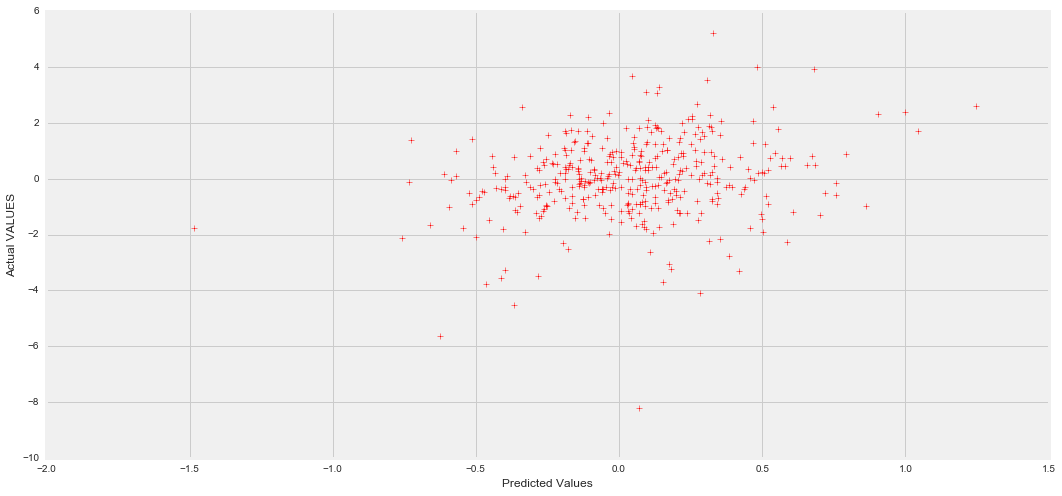

In [320]:
print "MSE:", mean_squared_error(y, predictions)
plt.figure(figsize=(16,8))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual VALUES")
plt.show()

# Logistic Regression

In [381]:
#Single Logistic Regression model.
X = testDF[[1,2,3,4,5,6,8,9]]
y = testDF["value_binary"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=69)

# X_train = testDF[[1,2,3,4,5,6,8,9]][:-20]
# Y_train = testDF['value_binary'][:-20]

# X_test = testDF[[1,2,3,4,5,6,8,9]][-20:]
# Y_test = testDF['value_binary'][-20:]


#lr = xgboost.XGBClassifier()
lr = LogisticRegressionCV(Cs=20, cv=10)
lr.fit(X_train, Y_train)

#cv = StratifiedKFold(y, n_folds=100, shuffle=True, random_state=69)
#y_pred = cross_val_predict(lr, X, y, cv=cv, n_jobs=-1)

y_pred = lr.predict(X_test)
# y_score = lr.decision_function(X_test)

conmat = np.array(confusion_matrix(Y_test, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion)
print classification_report(Y_test,y_pred)

        predicted_over  predicted_under
over               13                9
under               9               12
             precision    recall  f1-score   support

          0       0.57      0.57      0.57        21
          1       0.59      0.59      0.59        22

avg / total       0.58      0.58      0.58        43



In [363]:
number=0
base=0
for x in range(len(y)):
    if y[x] == y_pred[x]:
        number+=1
    if y[x] == 1:
        base+=1
print number/float(len(y)), base/float(len(y))

0.534278959811 0.510638297872


In [380]:
print 'ROC Area Under Curve Score:', roc_auc_score(Y_test, y_score)
""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high/low income', fontsize=18)
plt.legend(loc="lower right")
plt.show()

ROC Area Under Curve Score:

ValueError: Found input variables with inconsistent numbers of samples: [43, 12]

In [369]:
coef = pd.DataFrame([X.columns.values.tolist(), lr.coef_[0].tolist()], index=['features', 'coef']).T
coef.sort_values(by='coef', ascending=False)

,features,coef
2,polarity,21.0803
3,positive_score,16.3118
4,tone,11.5433
1,negative_score,4.76849
5,word_count,0.111645
7,Volatility,0.0331253
6,shifted_value,-0.115684
0,activity,-16.5201


In [376]:
# Unused section used to increase True Positives.
# Further testing is required.

Y_pp = pd.DataFrame(lr.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
Y_pp['pred_class_thresh50'] = y_pred

# Adjust number to change how it predicts. default = 0.5
Y_pp['pred_class_thresh_adjust'] = [1 if x >= 0.5 else 0 for x in Y_pp.class_1_pp.values]

#print(Y_pp.iloc[0:10])

conmat_10 = np.array(confusion_matrix(Y_test, Y_pp['pred_class_thresh_adjust'].values, labels=[1,0]))

confusion_10 = pd.DataFrame(conmat_10, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion_10)
print classification_report(Y_test,y_pred)

       predicted_over  predicted_under
over               13                9
under               9               12
             precision    recall  f1-score   support

          0       0.57      0.57      0.57        21
          1       0.59      0.59      0.59        22

avg / total       0.58      0.58      0.58        43



In [382]:
# This method of optimization decreases precision and increases False Negatives and decreases True Positives

logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=20)
gs.fit(X_train, Y_train)

logreg = LogisticRegression(C=gs.best_params_['C'],penalty=gs.best_params_['penalty'])
cv_model = logreg.fit(X_train, Y_train)
cv_pred = cv_model.predict(X_test)

conmat = np.array(confusion_matrix(Y_test, cv_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])
print(confusion)
print classification_report(Y_test, cv_pred)

       predicted_over  predicted_under
over               19                3
under              20                1
             precision    recall  f1-score   support

          0       0.25      0.05      0.08        21
          1       0.49      0.86      0.62        22

avg / total       0.37      0.47      0.36        43



# Cluster Models.

In [383]:
cv = StratifiedKFold(y, n_folds=100, shuffle=True, random_state=69)

dt = DecisionTreeClassifier(class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced')
et = ExtraTreesClassifier(class_weight='balanced')
kc = KNeighborsClassifier()

bdt = BaggingClassifier(dt)
brf = BaggingClassifier(rf)
bet = BaggingClassifier(et)
bkc = BaggingClassifier(kc)

cdt = cross_val_score(dt, X, y, cv=cv, n_jobs=-1)
crf = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
cet = cross_val_score(et, X, y, cv=cv, n_jobs=-1)
ckc = cross_val_score(kc, X, y, cv=cv, n_jobs=-1)

cbdt = cross_val_score(bdt, X, y, cv=cv, n_jobs=-1)
cbrf = cross_val_score(brf, X, y, cv=cv, n_jobs=-1)
cbet = cross_val_score(bet, X, y, cv=cv, n_jobs=-1)
cbkc = cross_val_score(bkc, X, y, cv=cv, n_jobs=-1)


print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", cdt.mean().round(3), cdt.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", crf.mean().round(3), crf.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees", cet.mean().round(3), cet.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Nearest Neighbor", ckc.mean().round(3), ckc.std().round(3)))
print 
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree Bagging", cbdt.mean().round(3), cbdt.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Bagging", cbrf.mean().round(3), cbrf.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees Bagging", cbet.mean().round(3), cbet.std().round(3)))
print("{} Score:\t{:0.3} ± {:0.3}".format("Nearest Neighbor Bagging", cbkc.mean().round(3), cbkc.std().round(3)))

Decision Tree Score:	0.511 ± 0.23
Random Forest Score:	0.487 ± 0.233
Extra Trees Score:	0.478 ± 0.241
Nearest Neighbor Score:	0.522 ± 0.231

Decision Tree Bagging Score:	0.49 ± 0.212
Random Forest Bagging Score:	0.515 ± 0.232
Extra Trees Bagging Score:	0.485 ± 0.208
Nearest Neighbor Bagging Score:	0.529 ± 0.237


,dt_importance,rf_importance,et_importance
word_count,0.218548,0.128044,0.138525
activity,0.143334,0.128995,0.113543
positive_score,0.129244,0.145315,0.123635
tone,0.123594,0.107795,0.125758
polarity,0.118615,0.129202,0.124039
Volatility,0.114418,0.118252,0.131187
shifted_value,0.100988,0.124638,0.108398
negative_score,0.051260,0.117760,0.134915


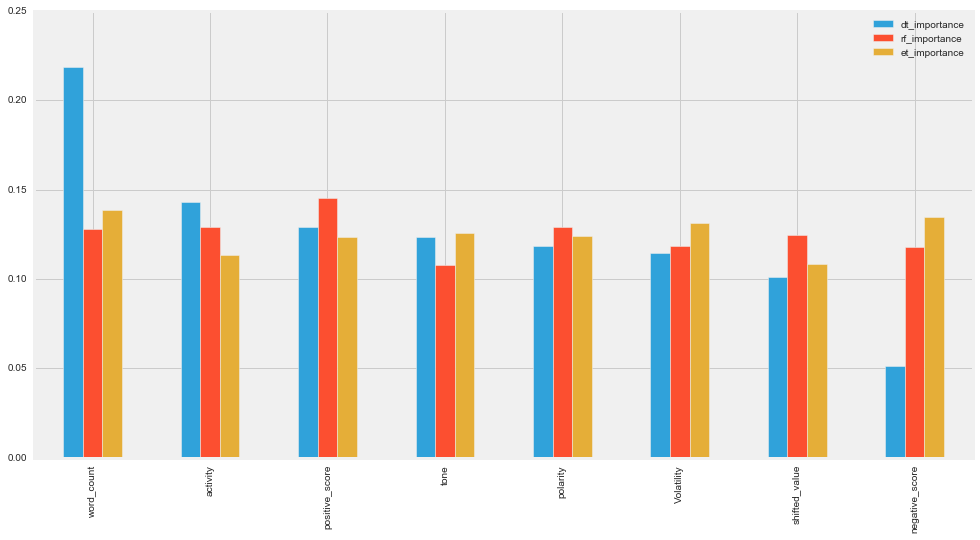

In [384]:
dt.fit(X, y)
rf.fit(X, y)
et.fit(X, y)
kc.fit(X, y)

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('dt_importance',
                                                                   ascending=False)

                           
importances.plot(kind='bar', figsize=(15,8))
importances.head(10)

       predicted_over  predicted_under
over               13                9
under              10               11
             precision    recall  f1-score   support

          0       0.55      0.52      0.54        21
          1       0.57      0.59      0.58        22

avg / total       0.56      0.56      0.56        43

ROC Area Under Curve Score: 0.595238095238


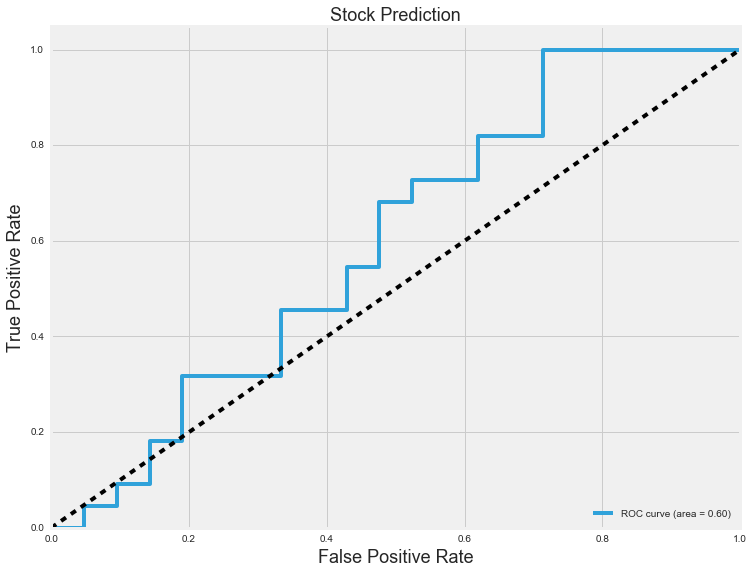

In [385]:
# GridSearch ExtraTrees. Unused.

gs2 = GridSearchCV(ExtraTreesClassifier(min_samples_leaf=10),
                  {'n_estimators': np.arange(10,50,10),
                  'max_features': np.arange(1,5,1)},
                  cv=10)
gs2.fit(X_train,Y_train)
y_pred2 = gs2.predict_proba(X_test)
tempDF = pd.DataFrame(y_pred2)
tempDF['actual'] = np.array(Y_test)
tempDF['threshold'] = tempDF[1].map(lambda x: 0 if x < 0.5 else 1)



conmat = np.array(confusion_matrix(Y_test, tempDF['threshold'], labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion)
print classification_report(Y_test, tempDF['threshold'])

print 'ROC Area Under Curve Score:', roc_auc_score(Y_test, tempDF[1])
""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, tempDF[1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Stock Prediction', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Test Data Prep

In [330]:
start = datetime(2016, 11, 14)
end = datetime(2016, 12, 13)
moob = web.DataReader('SPY', 'google', start, end)
moob.reset_index(inplace=True)
moob['day_diff'] = moob['Close'] - moob['Open']
moob = moob[[0,6]]
moob['Volatility'] = (moob['day_diff'].rolling(window=7,center=False).std()*np.sqrt(52)).shift()
moob['shifted_value'] = moob[[1]].shift()
moob.dropna(inplace=True)
moob.reset_index(drop=True, inplace=True)
moob['DATE'] = moob['Date']

moob['Date'] = [str(moob['Date'][x].year) + '{:02d}'.format(moob['Date'][x].month) + '{:02d}'.format(moob['Date'][x].day) for x in range(len(moob))]

moob['DATE'] = moob['DATE'] - timedelta(days=1)
moob['DATE'] = [str(moob['DATE'][x].year) + '{:02d}'.format(moob['DATE'][x].month) + '{:02d}'.format(moob['DATE'][x].day) for x in range(len(moob))]
moob

,Date,day_diff,Volatility,shifted_value,DATE
0,20161123,0.72,5.172164,0.07,20161122
1,20161125,0.42,4.542368,0.72,20161124
2,20161128,-0.68,3.936496,0.42,20161127
3,20161129,0.39,4.949014,-0.68,20161128
4,20161130,-1.25,4.509871,0.39,20161129
5,20161201,-1.16,5.721169,-1.25,20161130
6,20161202,0.01,5.817609,-1.16,20161201
7,20161205,0.35,5.794579,0.01,20161204
8,20161206,0.48,5.343821,0.35,20161205
9,20161207,3.08,5.413430,0.48,20161206


In [143]:
def predict_today()
    test_variable = time.strftime("%Y%m%d")
    date_variable = pd.to_datetime(test_variable)
    date_variable = date_variable - timedelta(days=1)
    date_variable = str(date_variable.year) + '{:02d}'.format(date_variable.month) + '{:02d}'.format(date_variable.day)

    download_data(test_variable, date_variable)
    csv_df = tone_parse(csv_to_df_no_GCAM())
    csv_df['Date'] = [pd.to_datetime(datetime.strptime(str(x), '%Y%m%d%H%M%S')) for x in csv_df['Date']]
    csv_df = csv_df.set_index('Date')
    csv_df = csv_df.resample('h').mean()
    csv_df.dropna(inplace=True)
    csv_df.reset_index(inplace=True)
    temp = csv_df.columns[1:]
    test = pd.DataFrame([np.polyfit(csv_df.index, csv_df[x],1)[0] for x in csv_df.columns[1:].tolist()]).T
    test.columns = temp.tolist()
    delete_csv()
    test['shifted_value'] = testdata['value'][11]
    roll_test = moob['day_diff'].rolling(window=7,center=False).std()*np.sqrt(52)
    test['Volatility'] = roll_test[len(roll_test)-1]
    return test

In [ ]:
# test = predict_today()

In [335]:
test = pd.DataFrame([np.polyfit(csv_df.index, csv_df[x],1)[0] for x in csv_df.columns[1:].tolist()]).T
test.columns = temp.tolist()
test['shifted_value'] = testdata['value'][11]
roll_test = moob['day_diff'].rolling(window=7,center=False).std()*np.sqrt(52)
test['Volatility'] = roll_test[len(roll_test)-1]

In [336]:
test

,tone,positive_score,negative_score,polarity,activity,word_count,shifted_value,Volatility
0,0.021992,0.005142,-0.01685,-0.011708,-0.021844,-8.938504,1.1,9.269924


In [87]:
def main_func_test(time_run):
    if time_run == 0:
        return "Not enough time to finish one loop."
    
    # We good fam.
    try:
        final_df = pd.read_pickle('test_data.pkl')
    except IOError:
        final_df = pd.DataFrame()
    
    
    # Prevents my program from running over and breaking.
    if len(final_df)+time_run >= len(moob):
        upper_bound = len(moob)
    else:
        upper_bound = len(final_df)+time_run
    
    # Main for loop that downloads, cleans, and stores relevant data.
    for p in range(len(final_df), upper_bound):
        # Downloads the data from the internet for the specified date.
        download_data(moob['Date'][p], moob['DATE'][p])
        
        
        # --------- TONE Section -------- #
        csv_df = tone_parse(csv_to_df_no_GCAM())
        csv_df['Date'] = [pd.to_datetime(datetime.strptime(str(x), '%Y%m%d%H%M%S')) for x in csv_df['Date']]
        csv_df = csv_df.set_index('Date')
        csv_df = csv_df.resample('h').mean()
        csv_df.dropna(inplace=True)
        csv_df.reset_index(inplace=True)
        temp = csv_df.columns[1:]
        test = pd.DataFrame([np.polyfit(csv_df.index, csv_df[x],1)[0] for x in csv_df.columns[1:].tolist()]).T
        test.columns = temp.tolist()
        # --------- TONE Section -------- #

        
        final_df = pd.concat([final_df, test], ignore_index=True)
        delete_csv()
        final_df['Date'] = moob['Date']
        pd.to_pickle(final_df, 'test_data.pkl')
        final_df = pd.read_pickle('test_data.pkl')
    play(seinfeld)

In [93]:
# Runs main function
# main_func_test(run_time(70, 'm')) # m = minutes, h = hours      1 loop = ~5 minutes

In [349]:
testdata = pd.read_pickle('test_data.pkl')
testdata['value'] = moob['day_diff']
testdata['shifted_value'] = moob['shifted_value']
testdata['Volatility'] = moob['Volatility']
testdata['value_binary'] = [1 if float(x) > 0 else 0 for x in testdata['value']]

In [390]:
#Single Logistic Regression model.
#X = testDF[[1,2,3,4,5,6,8,9]]
#y = testDF["value_binary"]

#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=69)

X_train = testDF[[1,2,3,4,5,6,8,9]]
Y_train = testDF['value_binary']

X_test = testdata[[1,2,3,4,5,6,8,9]]
Y_test = testdata['value_binary']


lr = xgboost.XGBClassifier()
#lr = LogisticRegressionCV(Cs=20, cv=10)
lr.fit(X_train, Y_train)

# cv = StratifiedKFold(y, n_folds=100, shuffle=True, random_state=69)
# y_pred = cross_val_predict(lr, X, y, cv=cv, n_jobs=-1)

y_pred = lr.predict(X_test)
#y_score = lr.decision_function(X_test)

conmat = np.array(confusion_matrix(Y_test, y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['over', 'under'],
                            columns=['predicted_over','predicted_under'])

print(confusion)
print classification_report(Y_test,y_pred)

       predicted_over  predicted_under
over                6                3
under               1                2
             precision    recall  f1-score   support

          0       0.40      0.67      0.50         3
          1       0.86      0.67      0.75         9

avg / total       0.74      0.67      0.69        12



In [353]:
# Test Model Performance by finding mean scores of 100 runs.
# Problem is this finds the mean of different Y's which have different values every time.
# This is bad.

final_results = []
default_results = []
test_results = []
base_accuracy = []
better_count = 0

for count in range(1):
    #X = testDF[[1,2,3,4,5,6,8,9]]
    #y = testDF["value_binary"]

    #X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    
    
    X_train = testDF[[1,2,3,4,5,6,8,9]]
    Y_train = testDF['value_binary']

    X_test = testdata[[1,2,3,4,5,6,8,9]]
    Y_test = testdata['value_binary']

    
    
    lr = xgboost.XGBClassifier()
    #lr = LogisticRegressionCV(Cs=10, cv=10)
    lr.fit(X_train,Y_train)

    y_pred = lr.predict(X_test)

    #--------This section needs to be re-evaluated and editted--------#  Done?
    Y_test_index = pd.DataFrame(Y_test).reset_index()
    Y_test_and_predict = pd.concat((Y_test_index, pd.DataFrame(y_pred)),axis=1)

    Y_test_and_predict = Y_test_and_predict.set_index('index')
    Y_test_and_predict['guess'] = Y_test_and_predict[0]
    Y_test_and_predict.pop(0)
    fest = pd.concat((Y_test_and_predict, testDF['value']), axis=1).dropna()
    fest.reset_index(drop=True, inplace=True)

    positive, negative = 0, 0
    for x in range(len(fest)):
        if fest['guess'][x] == 1:
            if fest['value_binary'][x] == fest['guess'][x]:
                positive += abs(fest['value'][x])
            else:
                negative += abs(fest['value'][x])
    #---------------------------------------------------------------#
    
    results = positive - negative
    final_results.append(results)
    
    conmat = confusion_matrix(Y_test, y_pred, labels=[1,0])
    test_results.append((conmat[0][0]+conmat[1][1])/float(len(Y_test)))
    
    #if conmat[0][0] + conmat[0][1] > conmat[1][0] + conmat[1][1]:
    base_accuracy.append((conmat[0][0]+conmat[0][1])/float(len(Y_test)))
    #else:
    #    base_accuracy.append((conmat[1][0]+conmat[1][1])/float(len(Y_test)))
    
    right_pos = [x for x in fest['value'] if x > 0]
    right_neg = [x for x in fest['value'] if x < 0]
    dresults = np.sum(right_pos) - abs(np.sum(right_neg))
    default_results.append(dresults)
    
    if results >= dresults:
        better_count+=1
print "Mean S&P500 Model Performance:", np.mean(final_results)
print "Mean S&P500  Base Performance:", np.mean(default_results)
print 'Mean of Model Accuracy:', np.mean(test_results)
print 'Mean of  Base Accuracy:', np.mean(base_accuracy)
print 'Model Standard Deviation:', np.std(test_results).round(3)
print 'Number of times model is better than random chance. Out of 1:', better_count

Mean S&P500 Model Performance: 7.93
Mean S&P500  Base Performance: 1.61
Mean of Model Accuracy: 0.666666666667
Mean of  Base Accuracy: 0.75
Model Standard Deviation: 0.0
Number of times model is better than random chance. Out of 1: 1


In [355]:
update_df = pd.concat((testDF, testdata), ignore_index=True)

In [407]:
X_train = update_df[[1,2,3,4,5,6,8,9]]
Y_train = update_df['value_binary']
X_test = test[[4,2,3,1,0,5,6,7]]

for x in range(2):
    if x == 0:
        lr = xgboost.XGBClassifier()
        lr.fit(X_train, Y_train)
        y_pred = lr.predict(X_test)
        if y_pred[0]==0:
            print '           XG Boost - Predict Down'
        else:
            print "           XG Boost - Predict Up"
    else:
        lr = LogisticRegressionCV(Cs=20, cv=10)
        lr.fit(X_train, Y_train)
        y_pred = lr.predict(X_test)
        if y_pred[0]==0:
            print 'Logistic Regression - Predict Down'
        else:
            print "Logistic Regression - Predict Up"


gs2 = GridSearchCV(ExtraTreesClassifier(min_samples_leaf=10),
                  {'n_estimators': np.arange(10,50,10),
                  'max_features': np.arange(1,5,1)},
                  cv=10)

gs2.fit(X_train,Y_train)
y_pred2 = gs2.predict_proba(X_test)
tempDF = pd.DataFrame(y_pred2)
if tempDF[1][0] > .5:
    print '        Extra Trees - Predict Up'
else:
    print "        Extra Trees - Predict Down"

           XG Boost - Predict Down
Logistic Regression - Predict Down
        Extra Trees - Predict Down


In [394]:
start = datetime(2015, 2, 22)
end = datetime(2016, 12, 13)
t = web.DataReader('SPY', 'google', start, end)
t.reset_index(inplace=True)
t['day_diff'] = t['Close'] - t['Open']
t['high_diff'] = t['High'] - t['Open']

In [398]:
t.head()

,Date,Open,High,Low,Close,Volume,day_diff,high_diff
0,2015-02-23,210.94,211.21,210.48,211.21,74411054,0.27,0.27
1,2015-02-24,211.12,212.05,210.76,211.81,72472263,0.69,0.93
2,2015-02-25,211.66,212.24,211.22,211.63,73061687,-0.03,0.58
3,2015-02-26,211.52,211.71,210.65,211.38,72697868,-0.14,0.19
4,2015-02-27,211.26,211.58,210.60,210.66,108075972,-0.60,0.32


In [402]:
test_list = [t['high_diff'][x] for x in range(len(t)) if t['day_diff'][x] < 0]

In [404]:
print 'Average High on days that Closed lower than it Opened.', np.mean(test_list)

Average High on days that Closed lower than it Opened. 0.530747663551


In [406]:
pd.to_pickle(test, 'today_predict.pkl')